In [13]:
import sys
import os
import scipy
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as scs
import matplotlib.pyplot as plt
sys.path.insert(0,'../scripts_/')
#import files
from plot import *
from HypothesisPlot import HypothesisPlot
from DistributionPlots import DistributionPlots
#for pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [14]:
sys.path.append(os.path.abspath(os.path.join('data')))

In [15]:
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../data/AdSmartABdata.csv')
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


### Data Preparation

 COMPARE THE TWO GROUPS

In [19]:
answered = df.query('yes==1 or no==1')
ab_summary = answered.pivot_table(values='yes', index='experiment', aggfunc=np.sum)

ab_summary['total'] = answered.pivot_table(values='yes', index='experiment', aggfunc=lambda x: len(x))
ab_summary['no']=ab_summary['total']-ab_summary['yes']
ab_summary['baseline rate'] = answered.pivot_table(values='yes', index='experiment')
ab_summary

,yes,total,no,baseline rate
experiment,,,,
control,264,586,322,0.450512
exposed,308,657,349,0.468798


In [22]:
from scipy.stats import binom


control_plot = ab_summary['yes']['control']/ab_summary['total']['control']
exposed_plot = ab_summary['yes']['exposed']/ab_summary['total']['exposed']
tot_exp_plot = ab_summary['total']['exposed']
tot_cont_plot = ab_summary['total']['control']
cont_aware = ab_summary['yes']['control']
exp_aware = ab_summary['yes']['exposed']
    

pipe.fit_transform(df)

            yes  total   no  baseline rate
experiment                                
control     264    586  322       0.450512
exposed     308    657  349       0.468798


* The baseline rate is calculated by taking the number of conversions(yes) and dividing that by the number of social interaction(total saying yes and no)
* The conversion rate between control and exposed group is 0.018

PLOT OF AWARE

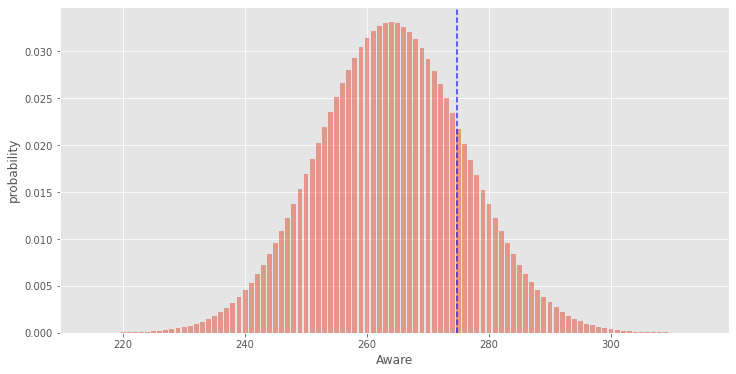

In [24]:
#plot of aware
DP = DistributionPlots()
HPP = HypothesisPlot()
DP.cont_distribution(cont_aware, tot_cont_plot, control_plot, exposed_plot)

* the result from the exposed group in the above plot is indicated by the blue dashline

PLOT OF THE TWO GROUPS

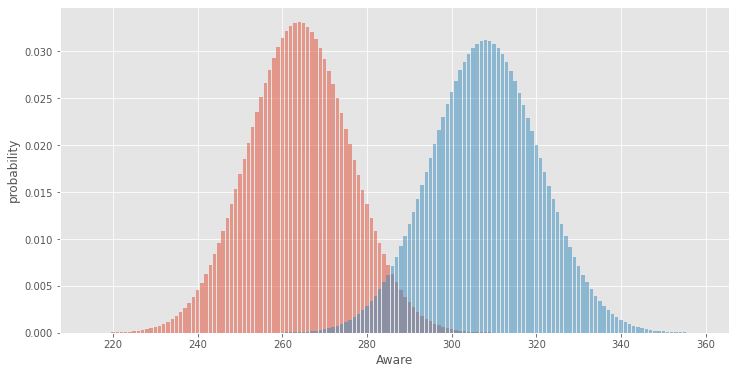

In [25]:
#plot of aware in exposed and controlled
DP.cont_exp_distribution(cont_aware, exp_aware, tot_cont_plot, tot_exp_plot, control_plot, exposed_plot) 

* we can see that the controlled group converted more than the exposed group

STANDARD ERROR OF MEAN FOR BOTH GROUPS

* to calculate the standard error of mean we need to understand what CLT theorem is
* CLT theorem suggests that by calculating mean of many samples we can calculate the true mean of the population(the data which the control group was taken)
* So standard error of the mean indicates how different the population mean is likely to be from the sample mean

In [28]:
SE_control = np.sqrt(control_plot * (1-control_plot)) / np.sqrt(tot_cont_plot)
SE_exposed = np.sqrt(exposed_plot * (1-exposed_plot)) / np.sqrt(tot_exp_plot)

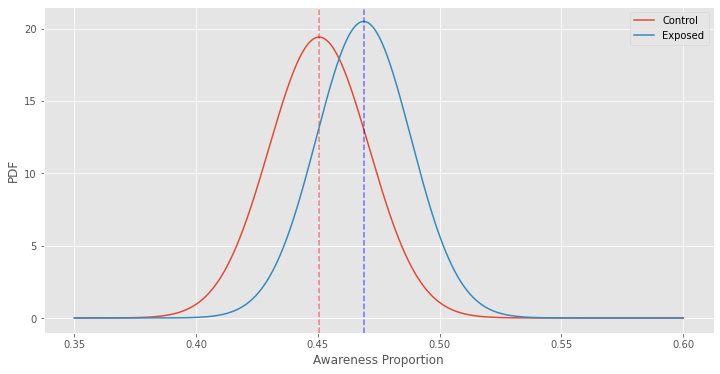

In [29]:
def standard_error(df):
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.linspace(.35, .6, 1000)

    yC = scs.norm(control_plot, SE_control).pdf(x)
    ax.plot(x, yC, label='Control')
    ax.axvline(x=control_plot, c='red', alpha=0.5, linestyle='--')

    yE = scs.norm(exposed_plot, SE_exposed).pdf(x)
    ax.plot(x, yE, label='Exposed')
    ax.axvline(x=exposed_plot, c='blue', alpha=0.5, linestyle='--')

    plt.legend()
    plt.xlabel('Awareness Proportion')
    plt.ylabel('PDF')
    plt.show()


standard_error(df)

* the dash lines represents the mean conversion rates for the control and exposed group

 VARIANCE OF THE SUM

* A basic property of variance is that the variance of the sum of two random independent variables is the sum of the variances.
* This means that the null hypothesis and alternative hypothesis will have the same variance, which will be, the sum of the variances for the control group and the test group.

In [21]:
#calculate variance of sum
var_cont = np.sqrt(control_plot * (1 - control_plot) / tot_cont_plot)
var_exp = np.sqrt(exposed_plot * (1 - exposed_plot) / tot_exp_plot)
var_cont, var_exp

(0.02055339057798332, 0.019468837373132736)

 NULL HYPOTHESIS VS. ALTERNATIVE HYPOTHESIS

* Null hypothesis(H0) suggests that there is no difference in brand awareness between conrolled and exposed group
* Alternative hypothesis(H1) suggests a difference in brand awarness

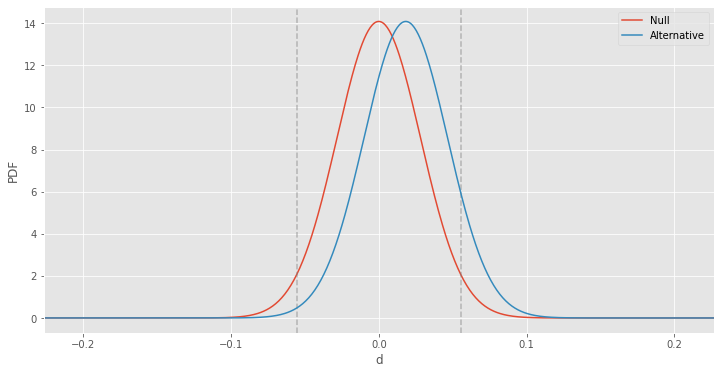

In [30]:
diff = exposed_plot - control_plot
abplot(tot_cont_plot, tot_exp_plot, control_plot, diff)

* the H1 curve suggests exposed group has higher conversion rate than controlled group

CALCULATE THE Z SCORE AND P-VALUE

In [22]:
diff = exposed_plot - control_plot
z_score = (diff) / np.sqrt(var_cont**2 + var_exp**2)
print(f"zscore is {z_score:0.5f}, with p-value {scs.norm().sf(z_score):0.5f}")

zscore is 0.64590, with p-value 0.25917


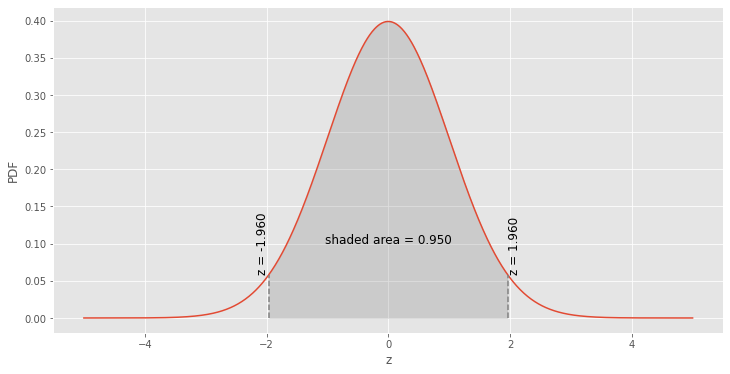

In [23]:
zplot(area=0.95)

* p-value helps us determine how likely it is to get a particular result when the null hypothesis is assumed to be true.
* if the null hypothesis is assuemed to be true, the p-value gives us an estimate of how strange our sample is
* if the p-value is very small(<0.05) then we are likely to reject the null hypothesis.

* But in our case the p-value is 0.259 greater than 0.05(significance level).
* Thus, we can't reject the null hypothesis

STATISTICAL POWER

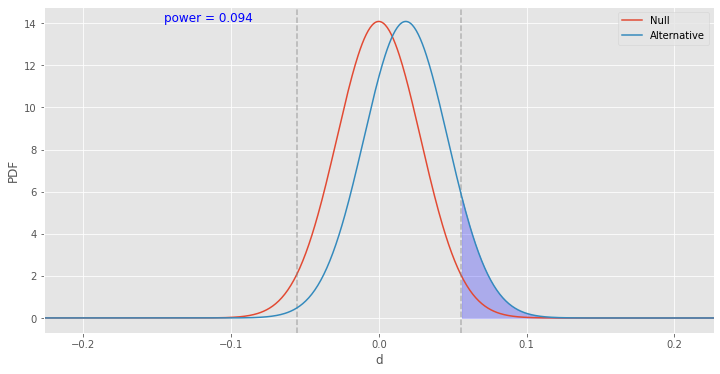

In [24]:
abplot(tot_cont_plot, tot_exp_plot, control_plot, diff, show_power=True)

* Statistical power is calculated by finding the area under the alternative hypothesis distribution and outisde of the confidence interval of the null hypothesis

STATISTICAL POWER AND SIGNIFICANCE LEVEL

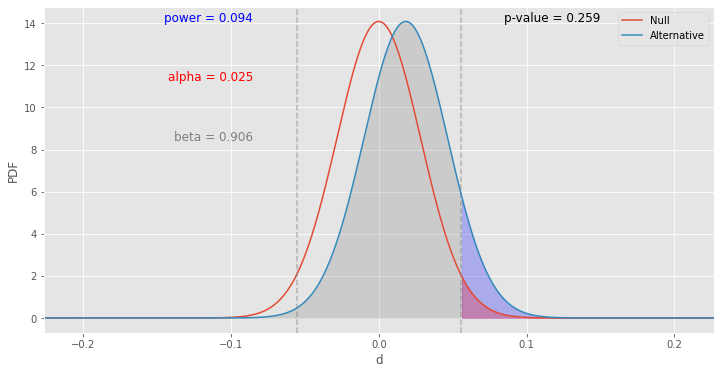

In [25]:
abplot(tot_cont_plot, tot_exp_plot, control_plot, diff, show_power=True, show_beta=True, show_alpha=True, show_p_value=True)

* The H0 which is $\alpha$ is the red.
* The alternate hypothesis is the blue one.
* The gray dashed lines are confidence interval at 95% (0.05).
* we get a small value for power wwhich is 9.4%
* The H1 which is $\beta$ indicates the chance of us making a typeII error is 90.6%. 
* Thus, we need to gather more data to make a sound conclusion

 CONFIDENCE LEVEL

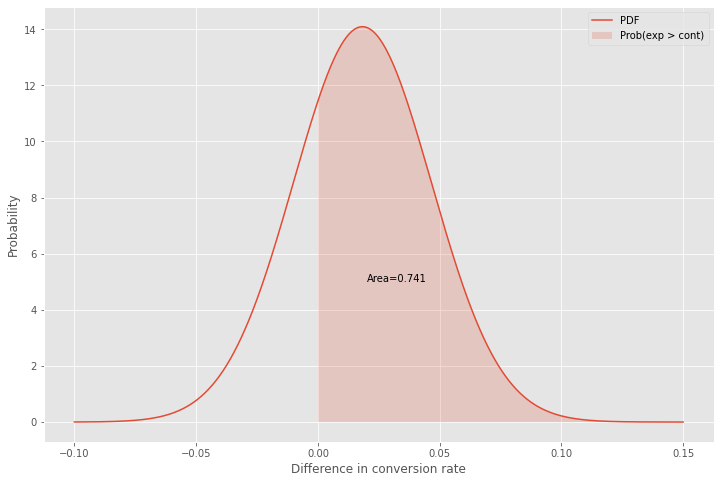

In [26]:
p = scs.norm(diff, np.sqrt(var_cont**2 + var_exp**2))
x = np.linspace(-0.1, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.subplots(figsize=(12, 8))
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x > 0, label="Prob(exp > cont)", alpha=0.2)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate")
plt.ylabel("Probability")
plt.show()

* A confidence interval displays the probability that a parameter will fall between a pair of values around the mean
* Our confidence interval is 0.741
* It means the exposed group have 74.1% awarness as the controlled one
* For the remaining percent the exposed group have different awareness from the controlled group

 OPTIMAL SAMPLE SIZE

* How much more data do we need to get the power to 80%?

In [27]:
def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    standard_norm = scs.norm(0, 1)
    Z_beta = standard_norm.ppf(power)
    Z_alpha = standard_norm.ppf(1-sig_level/2)
    pooled_prob = (bcr + bcr+mde) / 2
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2/ mde**2)
    return min_N



In [28]:
power = 0.8
sig_level = 0.05
sample_80 = round(min_sample_size(control_plot, diff, power,  sig_level))
print(f'Minimum sample size for 80% statistical power is : {sample_80} ')

Minimum sample size for 80% statistical power is : 11661 


* How much more data do we need to get the power to 90%?

In [29]:
power = 0.9
sig_level = 0.05
sample_80 = round(min_sample_size(control_plot, diff, power,  sig_level))
print(f'Minimum sample size for statistical 90% power is : {sample_80} ')

Minimum sample size for statistical 90% power is : 15610 


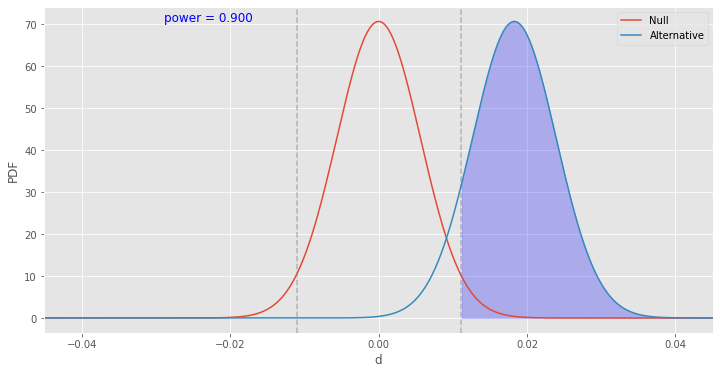

In [30]:
abplot(sample_80, sample_80, control_plot, diff, show_power=True)

If we increase the significance level...

In [31]:
power = 0.8
sig_level = 0.1
sample_80 = round(min_sample_size(control_plot, diff, power,  sig_level))
print(f'Minimum sample size for 80% statistical power is : {sample_80} ')

Minimum sample size for 80% statistical power is : 9185 
